In [1]:
from pathlib import Path
import sys
import os

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
from sentence_transformers import SentenceTransformer
from core.schemas import EmbeddedExample, EmbeddedDataset
from tqdm import tqdm

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def generate_embeddings(input_dataset, batch_size):

    embedded_examples = []

    for i in tqdm(
        range(0, len(input_dataset.examples), batch_size), 
        desc="Generating embeddings", 
        ncols=75
    ):
        batch = input_dataset.examples[i : i + batch_size]
        texts = [ex.text.replace("\n", " ") for ex in batch]

        embeddings = model.encode(texts)

        for ex, emb in zip(batch, embeddings):
            embedded_examples.append(
                EmbeddedExample(
                    example_id=ex.example_id,
                    text=ex.text,
                    embedding=emb
                )
            )

    return EmbeddedDataset(
            examples=embedded_examples,
            task_type=input_dataset.task_type
        )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
from core.data_manager import DataManager
from core.schemas import EmbeddedExample, EmbeddedDataset

# Create a DataManager instance for the NER task
data_manager = DataManager(task="financial_ner", base_dir=root / "tasks")
input_dataset = data_manager.load_input_dataset("Financial-NER-NLP_train.jsonl")

embedding_dataset = generate_embeddings(input_dataset, batch_size=64)

Generating embeddings: 100%|█████████████| 113/113 [04:37<00:00,  2.46s/it]


In [4]:
import numpy as np

embeddings = np.array([example.embedding for example in embedding_dataset.examples])
embeddings = np.vstack(embeddings)

In [5]:
from sklearn.manifold import TSNE

SEED = 42

tsne = TSNE(n_components=2, random_state=SEED)

embeddings_tsne = tsne.fit_transform(embeddings)

In [6]:
import warnings
import umap

warnings.filterwarnings('ignore')

umap_reducer = umap.UMAP(n_components=30, random_state=SEED)

embeddings_umap = umap_reducer.fit_transform(embeddings)

### HDBSCAN Parameters

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#

- `min_cluster_size` should be set to the smallest size grouping one wish to consider a cluster.

- `min_samples` if unspecified follows `min_cluster_size`, but if set it essentially provide a measure of how conservative one want the clustering to be.

- `cluster_selection_epsilon` is nice because it allows me to set a small `min_cluster_size` becasue groups of few points are important. The param sets a threshold so that clusters below it are not split up any further.

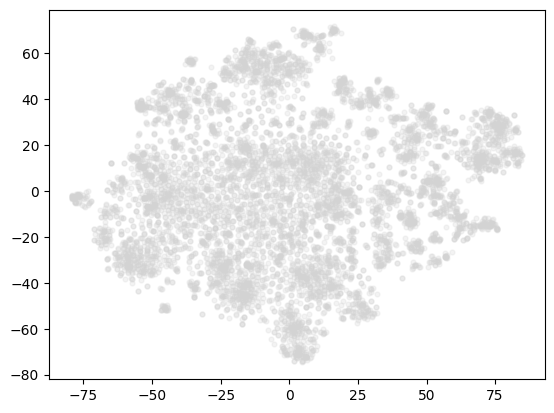

In [7]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c="lightgrey", alpha=0.25, s=12);

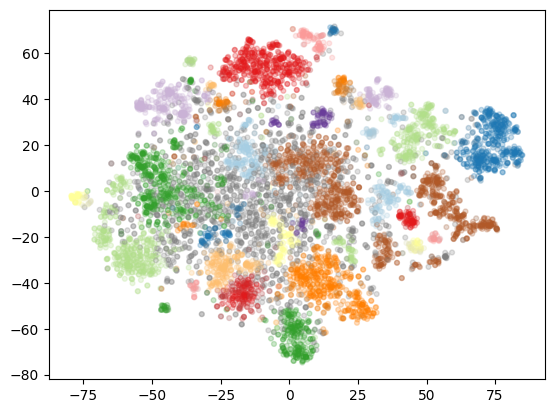

In [18]:
import hdbscan
import seaborn as sns

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15, 
    min_samples=10,
    cluster_selection_epsilon=0.3,
).fit(embeddings_umap)

color_palette = sns.color_palette("Paired", n_colors=len(set(clusterer.labels_))) 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_member_colors, alpha=0.25, s=12);

In [19]:
import plotly.express as px

fig = px.scatter(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    color=clusterer.labels_.astype(str),
)

fig.show()